In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  !git clone https://github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [3]:
#@title Setup environment and Colab general variables { display-mode: "form" }
%%capture
%run colab_setup.ipynb

In [ ]:
#@title Move images from Drive to temporary folder here to be able to train models
%%capture
%run move_raw_preprocess.ipynb

In [4]:
import os
import pandas as pd
import random
from tqdm import tqdm

from fastai.basics import *
from fastai.callback import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.medical.imaging import *

In [5]:
from utils import df_check_DICOM, filter_fnames
from preprocessing import DCMPreprocessDataset, HistScaled, HistScaled_all, init_bins

In [6]:
TRAIN_RESIZE = 256
BATCH_SIZE = 32

N_TRAIN = None
N_SAMPLES_BIN = 50 # None

In [7]:
all_check_DICOM_dict = {
    'ap': {
        'Modality': ['CR', 'DR', 'DX'],
        'SeriesDescription': ['RODILLA AP', 'TIBIA AP DIRECTO', 'Rodilla AP', 'rodilla AP', 'W098bDER Rodilla a.p.', 'T098aDER Rodilla a.p.', 'rodilla 1P AP', 'xeonllo DEREITO AP', 'xeonllo ESQUERDO AP'],
        'BodyPartExamined': ['LOWER LIMB', 'KNEE'],
        'function': lambda row: row.Rows/row.Columns >= 0.83,
    },
    # 'lat': {
    #     'Modality': ['CR', 'DR', 'DX'],
    #     'SeriesDescription': ['RODILLA LAT', 'TIBIA LAT DIRECTO', 'RODILLA LAT EN CARGA', 'T Rodilla lat', 'rodilla LAT', 'rodilla  LAT', 'W098bDER Rodilla lat.', 'T098aDER Rodilla lat', 'rodilla 1P LAT', 'xeonllo DEREITO LAT', 'xeonllo ESQUERDO LAT', 'TOBILLO EN CARGA LAT', 'PIE LAT EN CARGA', 'rodilla LAT dcha', 'rodilla LAT izda'],
    #     'BodyPartExamined': ['LOWER LIMB', 'KNEE']
    # },
    # 'two': {
    #     'Modality': ['CR', 'DR', 'DX'],
    #     'SeriesDescription': ['RODILLAS AP', 'rodilla AP y LAT', 'ambas rodillas AP', 'ambas rodillas LAT', 'rodilla (telemando) AP y LAT', 'rodilla AP y LAT', 'Rodillas LAT', 'Rodilla AP y LAT', 'ambolos dous xeonllos AP', 'ambolos dous xeonllos LAT', 'rodilla seriada', 'Rodillas AP', 'Rodillas LAT'],
    #     'BodyPartExamined': ['LOWER LIMB', 'KNEE']
    # },
    # 'other': {
    #     'Modality': ['CR', 'DR', 'DX'],
    #     'BodyPartExamined': ['THORAX', 'UPPER LIMB', 'KNEE STANDING',
    #    'RIBS', 'HAND', 'HIP', 'PIE EN CARGA', 'FOOT', 'ANKLE',
    #    'ELBOW', 'PELVIS', 'LSPINE', 'CSPINE']
    # }
}

targets = list(all_check_DICOM_dict.keys()) + ['other']

metadata_labels_path = os.path.join(PATH_PREFIX, 'metadata_labels.csv')

In [8]:
metadata_raw_path = os.path.join(PATH_PREFIX, 'metadata_raw.csv')

metadata_df = pd.read_csv(metadata_raw_path)

metadata_df.fname = metadata_df.fname.apply(
    lambda x: os.path.normpath(
        os.path.join(
            raw_preprocess_folder,
            os.path.split(x)[-1] + '.png'
        )
    )
    .replace(os.sep, '/')
)

# Initialize lists containing the filenames for each class
all_fnames = {}

for label, check_DICOM_dict in all_check_DICOM_dict.items():
    match_df = df_check_DICOM(metadata_df, check_DICOM_dict)
    all_fnames[label] = L(list(match_df.fname))

# Set as raw filenames all the ones in the metadata DataFrame
raw_fnames = L(list(metadata_df.fname))

# Filter on the filenames to not include undesired files
raw_fnames = L(filter_fnames(raw_fnames, metadata_raw_path))

# Label the rest of images as other
other_fnames = copy(raw_fnames)
for label, fnames in all_fnames.items():
    other_fnames = L(set(other_fnames.map(lambda path: str(path).replace(os.sep, '/'))) - set(fnames))

# Filter on the filenames to not include undesired files
other_fnames = filter_fnames(other_fnames, metadata_raw_path)
all_fnames['other'] = L(other_fnames)

# Select the corresponding part for training
if N_TRAIN is None:
    fnames = raw_fnames
else:
    fnames = random.choices(raw_fnames, k=N_TRAIN)

100%|██████████| 31171/31171 [00:07<00:00, 4418.82it/s]


In [9]:
print(targets)
[len(all_fnames[label]) for label in all_fnames]

['ap', 'other']


[17605, 31171]

In [13]:
# Trying to not use oversampling due to issues on relabeling data and because with 2 labels is already somehow balanced

# # Oversampling of all classes to meet the biggest one or reach max_n_times its own size
# max_samples = max([len(fnames) for _, fnames in all_fnames.items()])
# max_n_times = 4
# for label, fnames in all_fnames.items():
#     k = min(max_samples-len(fnames), max_n_times * len(fnames))
#     all_fnames[label] = all_fnames[label] + random.choices(all_fnames[label], k=k)

# print(targets)
# [len(all_fnames[label]) for label in all_fnames]

In [10]:
# Create DataFrame with the filenames and the corresponding label
labels_concat = []
for label, fnames in all_fnames.items():
    label_df = pd.DataFrame(list(fnames), columns=['fname'])
    label_df['Target'] = label
    labels_concat.append(label_df)

labels_df = pd.concat(labels_concat).set_index('fname', drop=False)

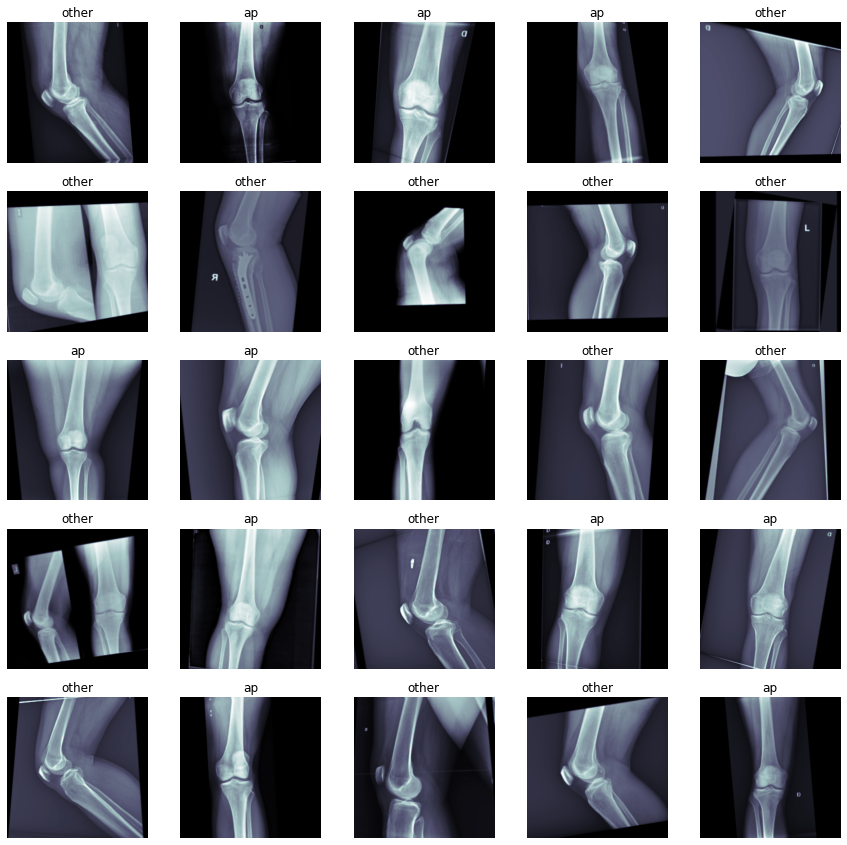

In [13]:
item_tfms = []

item_tfms.append(
  Resize(TRAIN_RESIZE, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
)

# bins = init_bins(L([fname for labels,fnames in all_fnames.items() for fname in fnames]), n_samples=N_SAMPLES_BIN, isDCM=False)
# item_tfms.append(
#     HistScaled_all(bins=bins)
# )

dls = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_x=ColReader('fname'),
    get_y=ColReader('Target'),
    splitter=RandomSplitter(0.2),
    item_tfms=item_tfms,
    batch_tfms=aug_transforms(),
).dataloaders(labels_df, bs=BATCH_SIZE, num_workers=0, shuffle_train=True, drop_last=True)
dls.show_batch(max_n=25, cmap=plt.cm.bone)

In [14]:
# Define the callbacks that will be used during training
callback_fns = [
        MixUp(),
        # partial(OverSamplingCallback),
        ShowGraphCallback(),
        EarlyStoppingCallback(monitor='val_loss', min_delta=0.05, patience=2),
    ]

# Adapt metrics depending on the number of labels
if len(targets) == 2:
    average = 'binary'
    roc_auc = RocAucBinary()
else:
    average = 'macro'
    roc_auc = RocAuc()

f1_score = F1Score(average=average)
precision = Precision(average=average)
recall = Recall(average=average)
learn = cnn_learner(
    dls,
    resnet18,
    metrics=[
        error_rate,
        roc_auc,
        f1_score,
        precision,
        recall
    ],
    callback_fns=callback_fns
)

# Regularization by using float precision of 16 bits
# This helps to not overfit because is more difficult to "memorize" images, but enough to learn
learn = learn.to_fp16()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=6.309573450380412e-07)

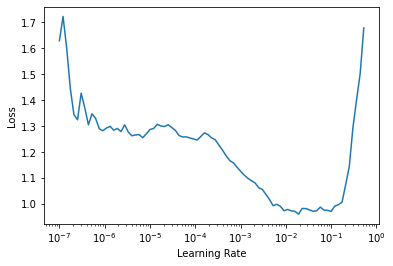

In [15]:
learn.lr_find()

In [16]:
%%time
learn.fine_tune(5, 0.002, freeze_epochs=1)

epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.228358    0.228106    0.069298    0.971107       0.944160  0.966678         0.922667      09:46     
epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.152350    0.137223    0.039057    0.985417       0.969292  0.967809         0.970778      10:12     
1         0.140262    0.121573    0.034034    0.988906       0.973165  0.974425         0.971908      09:59     
2         0.124569    0.123592    0.035264    0.989404       0.972267  0.971014         0.973523      10:08     
3         0.109794    02:56       


KeyboardInterrupt: 

In [56]:
%%time
learn.fine_tune(5, 0.002, freeze_epochs=1)

epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.277958    0.227296    0.080343    0.969344       0.921427  0.905052         0.938406      10:14     
epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.179199    0.161873    0.052077    0.983247       0.948043  0.949666         0.946426      11:45     
1         0.185517    0.181095    0.060814    0.983653       0.937246  0.972309         0.904624      11:43     
2         0.141279    0.144499    0.046167    0.986899       0.953458  0.965210         0.941989      11:48     
3         0.136833    0.139005    0.046852    0.989883       0.952447  0.970932         0.934653      11:49     
4         0.120696    0.142666    0.045739    0.989910       0.953549  0.972671         0.935165      11:47     
Wall time: 1h 9min 9s


Matching labels:   1%|          | 506/48776 [47:53<76:09:10,  5.68s/it]


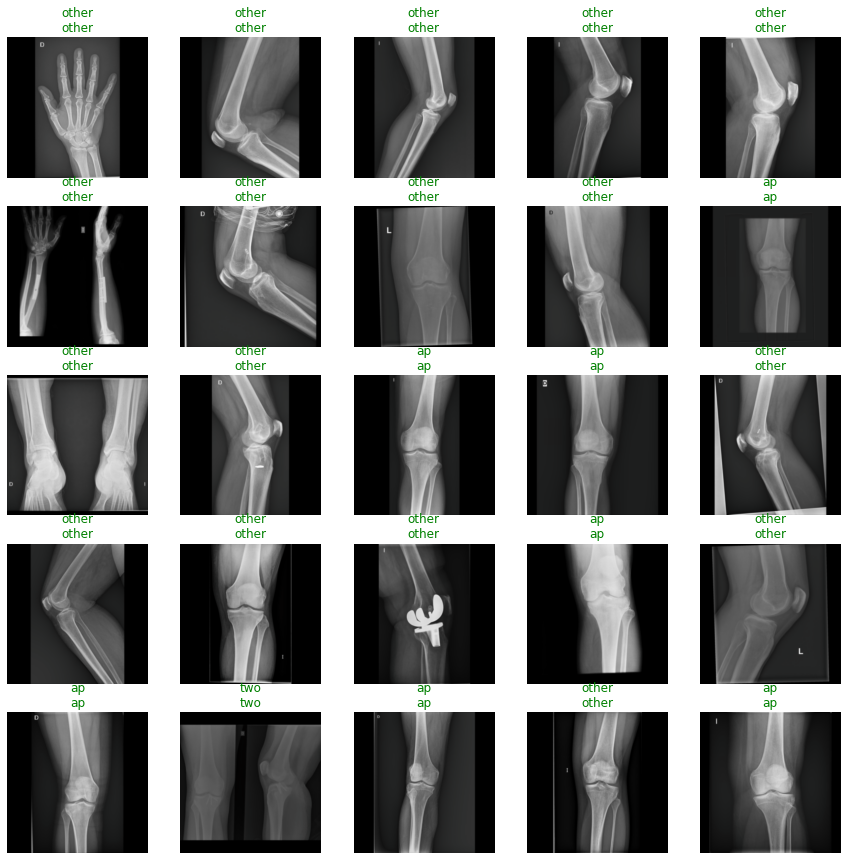

In [180]:
learn.show_results(max_n=25)

In [181]:
# Use too much RAM and the session is not capable of handle it
# interp = Interpretation.from_learner(learn)
# losses, idx = interp.top_losses()
# interp.plot_top_losses(25, figsize=(15,10))

RuntimeError: index_select(): Expected dtype int64 for index

In [57]:
# Generating DataLoader and select the paths that will be used for inference from raw_fnames
raw_dls = DataBlock(
    blocks=(ImageBlock(PILImageBW)),
    get_x=ColReader('fname'),
    item_tfms=item_tfms,
).dataloaders(pd.DataFrame(list(raw_fnames),columns=['fname']), bs=BATCH_SIZE, num_workers=0, shuffle_train=True, drop_last=True)

# paths = raw_dls.train.items + raw_dls.valid.items
paths = list(raw_dls.train.items.iloc[:,0].values) + list(raw_dls.valid.items.iloc[:,0].values)
labels = [labels_df.loc[path, 'Target'] if type(labels_df.loc[path, 'Target']) is not pd.Series else labels_df.loc[path, 'Target'][0] for path in tqdm(paths, desc='Matching labels')]

# Add DataSet from paths to the Test set of the learner
dl = learn.dls.test_dl(paths)

# Calculate predictions and probabilities
preds, _ = learn.get_preds(dl=dl)
max_probs, targs = preds.max(1)

In [58]:
# from glob import glob

# class_threshold = {
#     'Correct_label': 0.95,
#     'Wrong_label': 0.95,
# }

# raw_paths = glob(
#     os.path.join(
#         raw_folder,
#         '*',
#         '*'
#     )
# )
# raw_paths = [os.path.normpath(raw_path) for raw_path in raw_paths]

# raw_path_df = pd.DataFrame(raw_paths, columns=['Raw_path'])

# raw_path_df = raw_path_df.set_index(raw_path_df['Raw_path'].str.split(os.sep).str[-1])

In [59]:
data = {
    'Path': [],
    # 'Raw_path': [],
    'Label': [],
    'Raw_pred': [],
    'Pred': [],
    'Prob': [],
}
to_be_reviewed = []
for label, prob, targ, path in zip(labels, max_probs, targs, paths):
    path = Path(path)
    raw_pred = targets[targ]
    if label == targets[targ]:
        if prob >= class_threshold['Correct_label']:
            pred = raw_pred
        else:
            pred = 'Unsure_' + targets[targ] + '_' + label
            to_be_reviewed.append((path, targets[targ], label, prob))

    else:
        if prob >= class_threshold['Wrong_label']:
            pred = raw_pred
        else:
            pred = 'Unsure_' + targets[targ] + '_' + label
            to_be_reviewed.append((path, targets[targ], label, prob))
    # try:
    #     raw_path = raw_path_df.loc[os.path.splitext(path.name)[0], 'Raw_path']
    # except KeyError as e:
    #     row_match = raw_path_df.index.str.startswith(os.path.splitext(path.name)[0])
    #     proposal_raw_path = raw_path_df.loc[row_match]
    #     if len(proposal_raw_path) == 1:
    #         raw_path = proposal_raw_path['Raw_path'][0]
    #     elif os.path.splitext(path.name)[0][-2] == '_' or os.path.splitext(path.name)[0][-3] == '_':
    #         continue
    #     else:
    #         raw_path = ''
    #         print(f'Error fetching `{os.path.splitext(path.name)[0]}` image. Due to {e}')
    #         continue

    data['Path'].append(os.path.normpath(path).replace(os.sep, '/'))
    # data['Raw_path'].append(os.path.normpath(raw_path).replace(os.sep, '/'))
    data['Label'].append(label)
    data['Raw_pred'].append(raw_pred)
    data['Pred'].append(pred)
    data['Prob'].append(float(prob))

df = pd.DataFrame(data)
df.to_csv(metadata_labels_path, index=False)

In [60]:
def _open_thumb(fn, h, w): return Image.open(fn).to_thumb(h, w).convert('RGBA')

class ImagesCleanerDefaultPred(ImagesCleaner):
    "A widget that displays all images in `fns` along with a `Dropdown` with default value the prediction"

    def set_fns(self, fns, preds, labels, probs):
        self.fns = L(fns)[:self.max_n]
        # ims = parallel(_open_thumb, self.fns, h=self.height, w=self.width, progress=False,
        #                n_workers=min(len(self.fns)//10,defaults.cpus))
        ims = [_open_thumb(fn, h=self.height, w=self.width) for fn in self.fns]
        self.widget.children = [
            VBox([
                Label(f'{pred}/{label}/{prob:.4f}'),
                widget(im, height=f'{self.height}px'),
                Dropdown(options=self.opts, layout={'width': 'max-content'}, value=pred)
            ]) for im, pred, label, prob in zip(ims,preds,labels,probs)
        ]

    def values(self): return L(self.widget.children).itemgot(-1).attrgot('value')

In [61]:
# Check the cases which the model is totally sure and are also confirmed by metadata

df_rev = df.copy()
df_to_review = df_rev[(df_rev['Raw_pred'] == 'ap') & (df_rev['Pred'] == 'ap')].sort_values('Prob', ascending=False).iloc[0:100]
w = ImagesCleanerDefaultPred(targets,  max_n=len(df_to_review.index))
w.set_fns(
    list(df_to_review['Path']),
    list(df_to_review['Raw_pred']),
    list(df_to_review['Label']),
    list(df_to_review['Prob'])
)
w

Box(children=(VBox(children=(Label(value='ap/ap/0.0500'), Output(layout=Layout(height='128px')), Dropdown(inde…

In [52]:
# Check the unsure with lowest probability

df_to_review = df[~df['Pred'].isin(targets)].sort_values(['Raw_pred', 'Prob']).iloc[:100]
w = ImagesCleanerDefaultPred(targets,  max_n=len(df_to_review.index))
w.set_fns(
    list(df_to_review['Path']),
    list(df_to_review['Raw_pred']),
    list(df_to_review['Label']),
    list(df_to_review['Prob'])
)
w

Box(children=(VBox(children=(Label(value='ap/ap/0.0500'), Output(layout=Layout(height='128px')), Dropdown(inde…

In [62]:
w.change()

(#100) [(0, 'ap'),(1, 'ap'),(2, 'ap'),(3, 'ap'),(4, 'ap'),(5, 'ap'),(6, 'ap'),(7, 'ap'),(8, 'other'),(9, 'ap')...]

In [63]:
df['Final_pred'] = df['Pred']
for i, pred in w.change():
    idx = df_to_review.iloc[i].name
    df.loc[idx, 'Final_pred'] = pred
    df.loc[idx, 'Prob'] = np.nan

    # Update label image if required
    path =  Path(df.loc[idx, 'Path'])
    if path.parent.name != pred:
        labels_df.loc[path, 'Target'] = pred
        labels_df.loc[path, 'fname'] = path

df.to_csv(metadata_labels_path, index=False)

RFENM2PQ.png
Target                                                                               ap
Name: data\raw_preprocess\B9QRLS34IH35Ne224F008BS6SAGG41DNMOHK4I01C45H7RFENM2PQ.png, dtype: object
fname     data\raw_preprocess\EC7ST8R4V6QIEe2D1N66TK1QP2IG41DCE6K2SR0S4H8FFAC92IGOR.png
Target                                                                               ap
Name: data\raw_preprocess\EC7ST8R4V6QIEe2D1N66TK1QP2IG41DCE6K2SR0S4H8FFAC92IGOR.png, dtype: object
fname     data\raw_preprocess\A6VSJ87VLQSD1e5DLTCUQDPESTFG41DJ768HK10JFMDVIUD6505QD.png
Target                                                                               ap
Name: data\raw_preprocess\A6VSJ87VLQSD1e5DLTCUQDPESTFG41DJ768HK10JFMDVIUD6505QD.png, dtype: object
fname     data\raw_preprocess\33MKBKPBCM30AeFBQF688I6BI8VG41DAU6AGIT0B63GHNQ8TGPIO3.png
Target                                                                            other
Name: data\raw_preprocess\33MKBKPBCM30AeFBQF688I6BI8VG41DAU6AGIT0B63GHNQ8T